Trappist-1 comparing lines with Phoenix models.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy import interpolate
from astropy.convolution import convolve, Box1DKernel,convolve_fft, Gaussian1DKernel

%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [13]:
mpath = '/home/david/work/muscles/trappist-1/sp_models/'
kpath  = '../COS/' 

In [14]:
#Trappist d and r from peacock paper
d = 12.1*u.pc
r = 0.117*const.R_sun

In [15]:
scale = (r/d.to(u.m))**2
scale

<Quantity 4.75273828e-20>

In [16]:
ksp = os.listdir(kpath)

In [17]:
c_ii = [1334.532 ,1335.708]
n_v = [1238.821,1242.804]
c_iv = [1548.202, 1550.774]

In [18]:
mods = os.listdir(mpath)
mods

['TRAPPIST1_2A_fullres.txt',
 'TRAPPIST1_1A_fullres.txt',
 'TRAPPIST1_2B_fullres.txt']

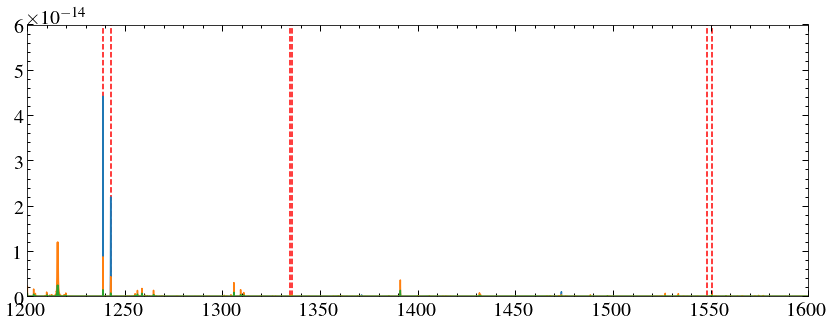

In [78]:
for mod in mods:
    mw, mf = np.loadtxt(mpath+mod, unpack=True, skiprows=1)
    plt.plot(mw, mf*scale)
    plt.xlim(1200, 1600)
    plt.ylim(0.0,0.6e-13)
[plt.axvline(line, ls ='--', c='r', zorder=-10) for line in np.concatenate((c_ii, n_v, c_iv))]

In [20]:
def model_convolve(mw, mf, w, res): #convolves a model with a gaussian
    res_pix = (res * len(w)) / (2.3548*(w[-1]-w[0])) #convert resolution to pixel scale
    mf1 = interpolate.interp1d(mw, mf, bounds_error=False, fill_value=0.)(w) #interpolate model onto measured wavelength
    gauss = Gaussian1DKernel(stddev=res_pix) #set up Gaussian
    new_mf = convolve_fft(mf1, gauss) #convolve model
    return new_mf


In [21]:
mods

['TRAPPIST1_2A_fullres.txt',
 'TRAPPIST1_1A_fullres.txt',
 'TRAPPIST1_2B_fullres.txt']

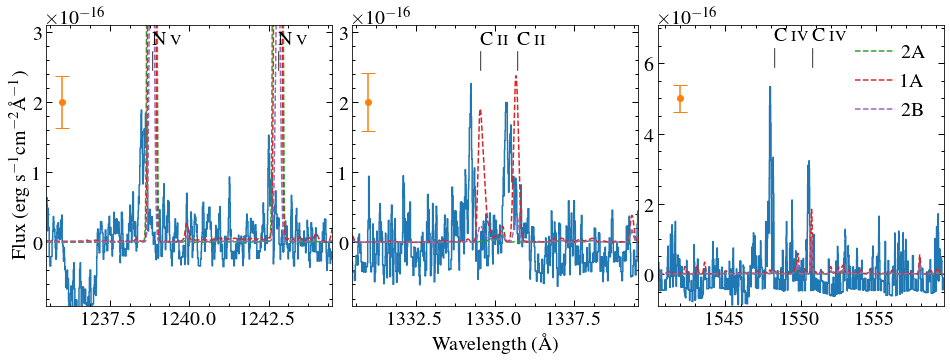

In [24]:
mw2a, mf2a = np.loadtxt(mpath+mods[0], unpack=True, skiprows=1)
mw1a, mf1a = np.loadtxt(mpath+mods[1], unpack=True, skiprows=1)
mw2b, mf2b = np.loadtxt(mpath+mods[2], unpack=True, skiprows=1)
mf2a, mf1a, mf2b = mf2a*scale, mf1a*scale, mf2b*scale
res=0.1

plt.subplots_adjust(top = 0.93, right = 0.99, left = 0.1, bottom = 0.15, wspace = 0.07)

plt.subplot(131)
data = readsav(kpath+ksp[0])
flux = convolve(data['Flux'],Box1DKernel(5))
error =  convolve(data['Err'],Box1DKernel(5))
plt.step(data['Wave'], flux)
plt.ylim(-0.9e-16,3.1e-16)
plt.xlim(1235.5, 1244.5)
[plt.annotate('N\,{\sc v}\n$|$',(n, 2.5e-16),size=20) for n in n_v]
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)
err = error[(data['Wave']>1235) & (data['Wave']<1245)]
plt.errorbar(1236, 2e-16, yerr= np.median(err), capsize = 7, marker='o')

mf2a_c = model_convolve(mw2a, mf2a, data['Wave'], res)
mf1a_c = model_convolve(mw1a, mf1a, data['Wave'], res)
mf2b_c = model_convolve(mw2b, mf2b, data['Wave'], res)
plt.plot(data['Wave'], mf2a_c, ls='--')
plt.plot(data['Wave'], mf1a_c, ls='--')
plt.plot(data['Wave'], mf2b_c, ls='--')

plt.subplot(132)
plt.step(data['Wave'], flux)
plt.ylim(-0.9e-16, 3.1e-16)
plt.xlim(1330.5, 1339.5)
[plt.annotate('C\,{\sc ii}\n$|$',(c, 2.5e-16),size=20) for c in c_ii]
plt.xlabel('Wavelength (\AA)', size=20)
err = error[(data['Wave']>1330) & (data['Wave']<1340)]
plt.errorbar(1331, 2e-16, yerr= np.median(err), capsize = 7, marker='o')
plt.plot(data['Wave'], mf2a_c, ls='--')
plt.plot(data['Wave'], mf1a_c, ls='--')
plt.plot(data['Wave'], mf2b_c, ls='--')


data = readsav(kpath+ksp[1])
flux = convolve(data['Flux'],Box1DKernel(5))
error =  convolve(data['Err'],Box1DKernel(5))
plt.subplot(133)
plt.step(data['Wave'], flux)
plt.ylim(-0.9e-16, 7.1e-16)
plt.xlim(1540.5, 1559.5)
[plt.annotate('C\,{\sc iv}\n$|$',(c, 6e-16),size=20) for c in c_iv]
err = error[(data['Wave']>1540) & (data['Wave']<1560)]
plt.errorbar(1542, 5e-16, yerr= np.median(err), capsize = 7, marker='o')#, ecolor='C1')


mf2a_c = model_convolve(mw2a, mf2a, data['Wave'], res)
mf1a_c = model_convolve(mw1a, mf1a, data['Wave'], res)
mf2b_c = model_convolve(mw2b, mf2b, data['Wave'], res)
plt.plot(data['Wave'], mf2a_c, ls='--', label= '2A')
plt.plot(data['Wave'], mf1a_c, ls='--', label='1A')
plt.plot(data['Wave'], mf2b_c, ls='--', label='2B')
plt.legend()

20190415 I have a combined hst file, so can do a comparision of the given model fluxes to the Hst

In [25]:
data = Table.read('../combined/TRAPPIST-1_hst+phoenix_v1.ecsv')

In [51]:
mlines = np.genfromtxt('phoenix_model_lines.txt', delimiter='\t', names=True, dtype=None,encoding=None)

In [52]:
mlines.dtype.names

('Species', 'lambda_angst', 'Model_1A', 'Model_2A', 'Model_2B', 'f0')

In [55]:
mlines['lambda_angst'] = mlines['lambda_angst']*u.AA

In [59]:
unit = 1e-18*u.erg/u.s /u.cm**2
mlines['Model_1A'], mlines['Model_2A'], mlines['Model_2B'] = mlines['Model_1A']*unit, mlines['Model_2A']*unit, mlines['Model_2B']*unit

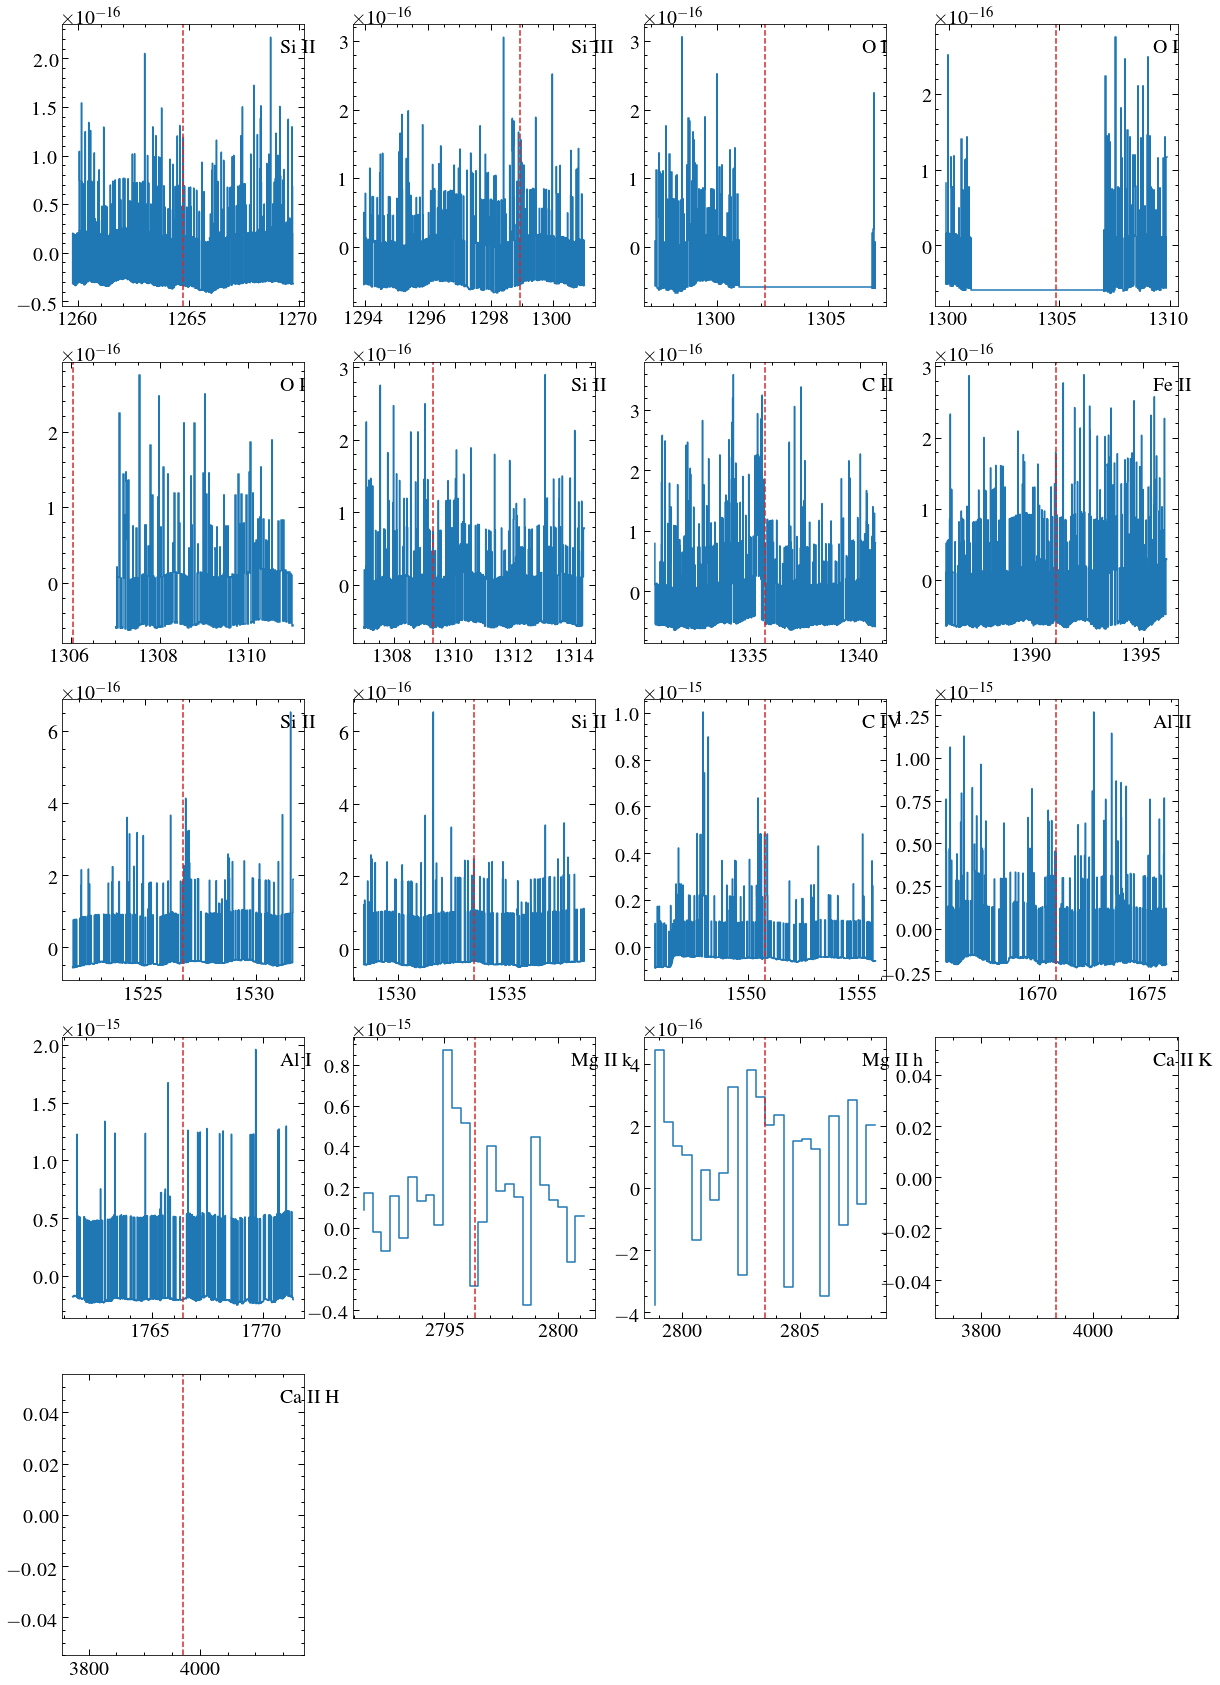

In [67]:
lines = mlines['lambda_angst']
plt.figure(figsize=(20, 30))
for i in range(len(lines)):
    line = lines[i]
    plt.subplot(5,4,i+1)
    mask = (data['WAVELENGTH'] > line-5) & (data['WAVELENGTH'] < line+5)
    plt.step(data['WAVELENGTH'][mask], data['FLUX'][mask])
    plt.axvline(line, ls='--', c='C3')
    plt.annotate(mlines['Species'][i], (0.9, 0.9), xycoords='axes fraction')
    

Ok so we have most of them. Oi lines are wiped out by airglow, I'll take another look at those and see if there's any way to improve. No- the airglow lines are broad and completaly dominate.

In [75]:
nolinesmask = (mlines['Species'] != 'O I')&(mlines['Species'] != 'Ca II K')&(mlines['Species'] != 'Ca II H')
dlines = mlines[nolinesmask]

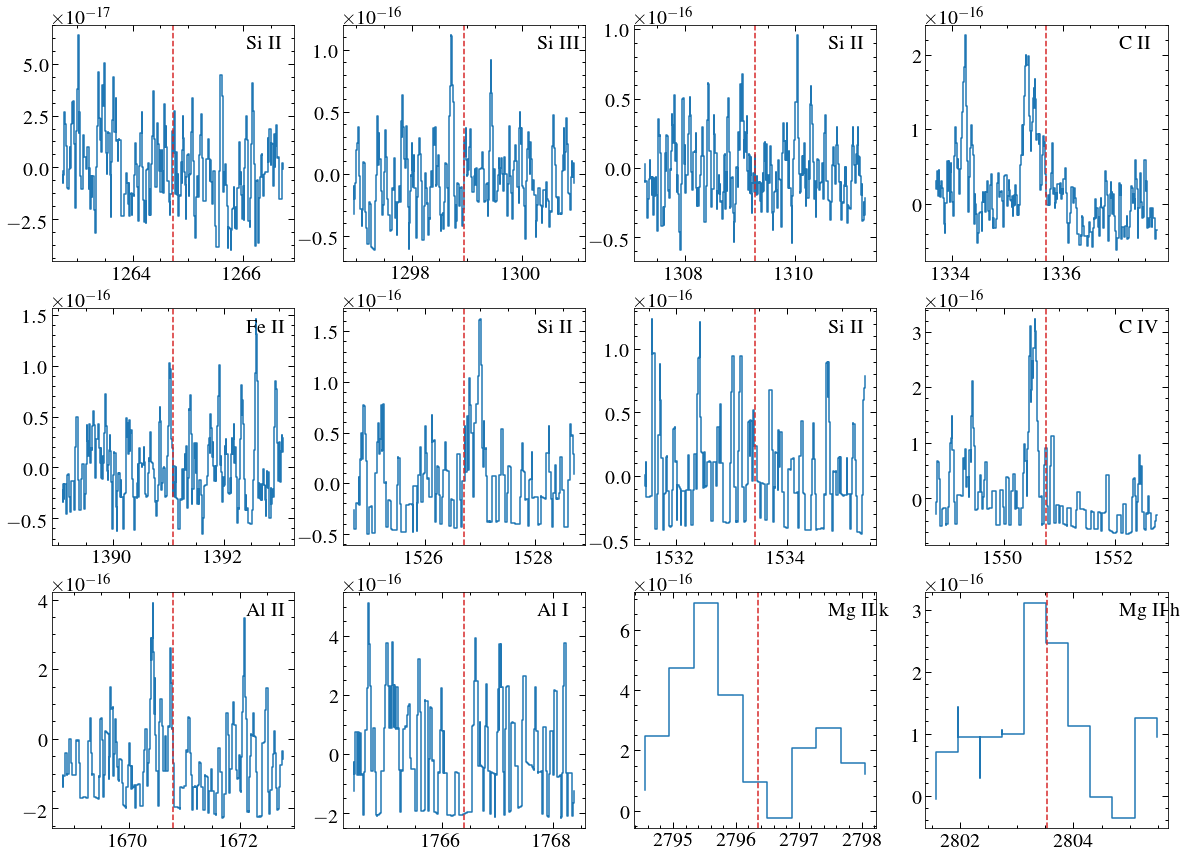

In [92]:
lines = dlines['lambda_angst']
plt.figure(figsize=(20, 20))
for i in range(len(lines)):
    line = lines[i]
    plt.subplot(4,4,i+1)
    mask = (data['WAVELENGTH'] > line-2) & (data['WAVELENGTH'] < line+2)
    flux = convolve(data['FLUX'][mask],Box1DKernel(5))
    plt.step(data['WAVELENGTH'][mask], flux)
    plt.axvline(line, ls='--', c='C3')
    plt.annotate(dlines['Species'][i], (0.8, 0.9), xycoords='axes fraction')
    

First thing to work out is how they calculated the integrated flux, i.e. width of line etc. Doesn't say in paper.

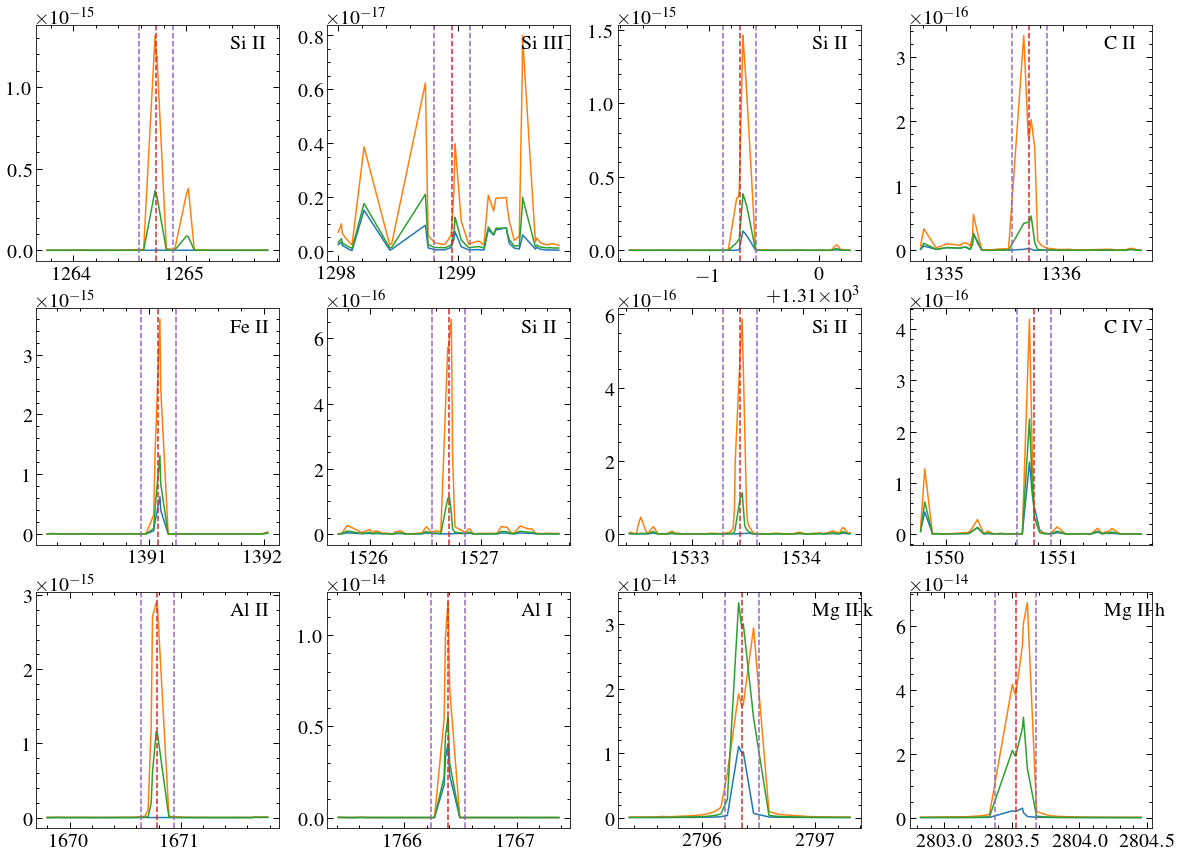

In [119]:
#mw2a, mf2a = np.loadtxt(mpath+mods[0], unpack=True, skiprows=1)
#mw1a, mf1a = np.loadtxt(mpath+mods[1], unpack=True, skiprows=1)
#mw2b, mf2b = np.loadtxt(mpath+mods[2], unpack=True, skiprows=1)
#mf2a, mf1a, mf2b = mf2a*scale, mf1a*scale, mf2b*scale

lines = dlines['lambda_angst']
plt.figure(figsize=(20, 20))
for i in range(len(lines)):
    line = lines[i]
    plt.subplot(4,4,i+1)
    for mw, mf in zip([mw2a, mw1a, mw2b], [mf2a, mf1a, mf2b]):
        mask = (mw > line-1) & (mw < line+1)
        plt.plot(mw[mask], mf[mask])
    #mask = (data['WAVELENGTH'] > line-2) & (data['WAVELENGTH'] < line+2)
    #plt.step(data['WAVELENGTH'][mask], data['FLUX'][mask])
    plt.axvline(line, ls='--', c='C3')
    plt.axvline(line+0.15, ls='--', c='C4')
    plt.axvline(line-0.15, ls='--', c='C4')
    
    plt.annotate(dlines['Species'][i], (0.8, 0.9), xycoords='axes fraction')
    
    

Looks like 0.3 A? But ours will be broader, may have to fit them (gulp).

In [87]:
lines = dlines['lambda_angst']
plt.figure(figsize=(20, 20))
for i in range(len(lines)):
    line = lines[i]
    #plt.subplot(4,4,i+1)
    strengths = []
    for mw, mf in zip([mw1a, mw2a, mw2b], [mf1a, mf2a, mf2b]):
        mask = (mw > line-0.15) & (mw < line+0.15)
        #plt.plot(mw[mask], mf[mask])
        strengths.append(np.trapz(mf[mask], mw[mask]))
    print(dlines['Species'][i], line, [st.value/1e-18 for st in strengths])
    #mask = (data['WAVELENGTH'] > line-2) & (data['WAVELENGTH'] < line+2)
    #plt.step(data['WAVELENGTH'][mask], data['FLUX'][mask])
    #plt.axvline(line, ls='--', c='C3')
    #plt.axvline(line+0.15, ls='--', c='C4')
    #plt.axvline(line-0.15, ls='--', c='C4')
    
   # plt.annotate(dlines['Species'][i], (0.8, 0.9), xycoords='axes fraction')
    

Si II 1264.73 [137.14071198720458, 0.07959674326199537, 38.00526324455754]
Si III 1298.95 [0.28079167178330205, 0.04813783768081047, 0.09836690989246692]
Si II 1309.28 [139.9956186435817, 10.464604971198082, 35.06623145200743]
C II 1335.71 [22.693518612310417, 0.18962773181619463, 3.9984321440887]
Fe II 1391.08 [225.27475040200176, 37.343144344951476, 77.70388438412277]
Si II 1526.71 [46.088677974333095, 0.10849250443267701, 7.4471311961166275]
Si II 1533.43 [41.45460338365288, 0.19422283339782756, 6.7736749187673295]
C IV 1550.77 [22.90652985851743, 9.844182325206972, 13.024174962119393]
Al II 1670.79 [317.9399048723638, 0.045548328880552845, 109.07578101162157]
Al I 1766.39 [1031.748176562304, 342.5414316926617, 447.8763135995567]
Mg II k 2796.35 [4174.507070933209, 1487.2045453265262, 5142.590937793106]
Mg II h 2803.53 [5549.1233532056585, 213.56195470145386, 2563.9465194467507]


<Figure size 1440x1440 with 0 Axes>

In [90]:
plt.figure(figsize=(20, 20))
for i in range(len(lines)):
    line = lines[i]
    #plt.subplot(4,4,i+1)
    strengths = []
    for mw, mf, mint in zip([mw1a, mw2a, mw2b], [mf1a, mf2a, mf2b], [dlines['Model_1A'], dlines['Model_2A'], dlines['Model_2B']]):
        mask = (mw > line-0.15) & (mw < line+0.15)
        #plt.plot(mw[mask], mf[mask])
        strengths.append(np.trapz(mf[mask], mw[mask])/mint[i])
    print(dlines['Species'][i], line, [st.value for st in strengths])


Si II 1264.73 [1.2373970223513902, 0.6633061938499615, 1.55440749466493]
Si III 1298.95 [0.968247144080352, 0.9627567536162094, 0.9836690989246692]
Si II 1309.28 [1.3579941666852429, 1.322958909127444, 1.3445640894174629]
C II 1335.71 [0.6200414921396288, 1.0534873989788591, 0.7377181077654428]
Fe II 1391.08 [1.069071518612385, 1.0128327731204632, 1.0232273424298495]
Si II 1526.71 [1.040611378964396, 1.205472271474189, 1.2579613506953764]
Si II 1533.43 [0.8696161817422462, 0.9711141669891379, 0.9760338499664738]
C IV 1550.77 [1.3379982393993826, 1.1803575929504764, 1.3249415017415453]
Al II 1670.79 [1.0251496255638224, 0.41407571709593494, 1.0778239230397388]
Al I 1766.39 [2.190873753131684, 2.2565311705708937, 2.834660212655422]
Mg II k 2796.35 [0.6033039046585199, 1.1605729065165173, 0.6214844227147006]
Mg II h 2803.53 [0.4911897923670023, 0.7441442374349415, 0.578385116750227]


<Figure size 1440x1440 with 0 Axes>

Ok so it varies by line, think I do need to fit the lines. Good news is it looks like there's a firm rv. https://ui.adsabs.harvard.edu/abs/2014MNRAS.439.3094B/abstract has v = 6 km s$^{-1}$

In [94]:
c = const.c.value

In [96]:
#line*(1.0-(delv/c)
dv = 6000.

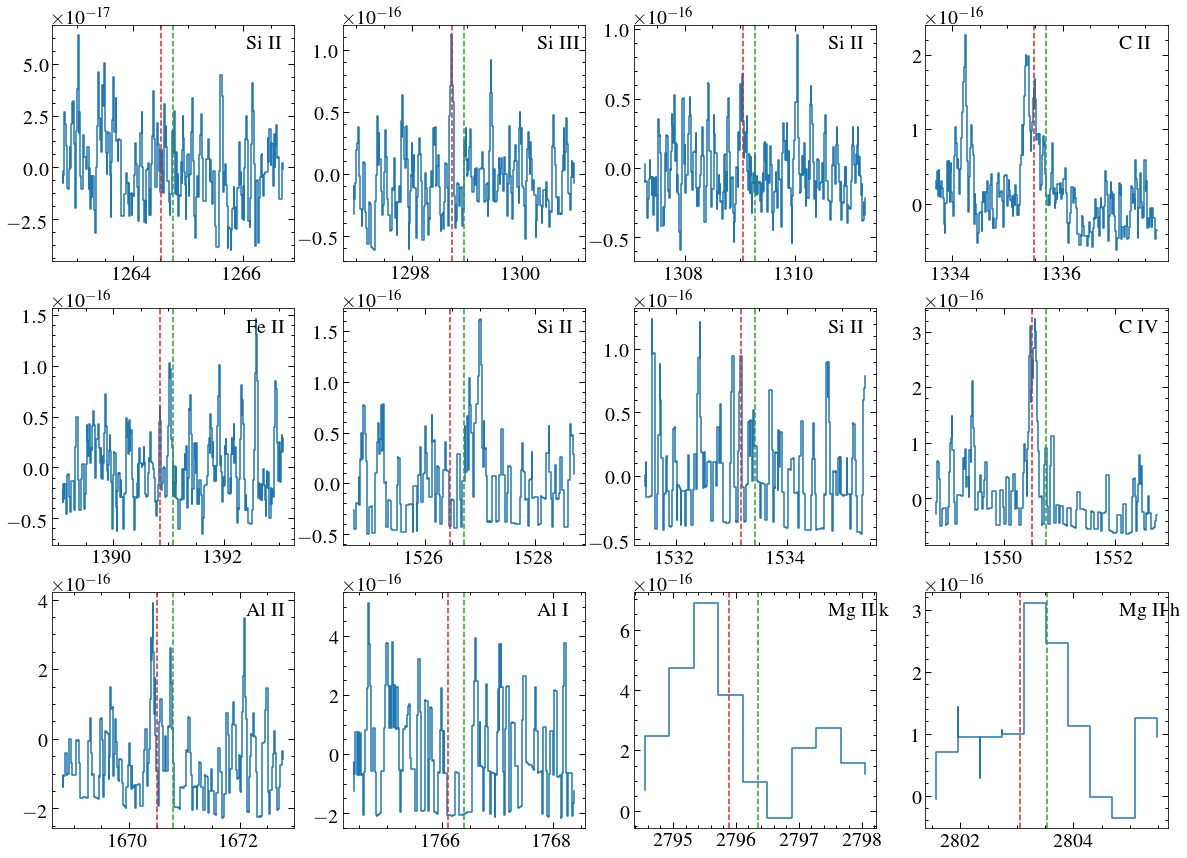

In [105]:
lines = dlines['lambda_angst']
plt.figure(figsize=(20, 20))
for i in range(len(lines)):
    line = lines[i]
    plt.subplot(4,4,i+1)
    mask = (data['WAVELENGTH'] > line-2) & (data['WAVELENGTH'] < line+2)
    flux = convolve(data['FLUX'][mask],Box1DKernel(5))
    plt.step(data['WAVELENGTH'][mask], flux)
    plt.axvline(line, ls='--', c='C2')
    plt.axvline(line*(1.0-(50000/c)), ls='--', c='C3')
    plt.annotate(dlines['Species'][i], (0.8, 0.9), xycoords='axes fraction')
    

So it's not 6... 60 seems a reasonable starting point..

In [108]:
from astropy.modeling import models, fitting

In [109]:
fitter = fitting.LevMarLSQFitter()

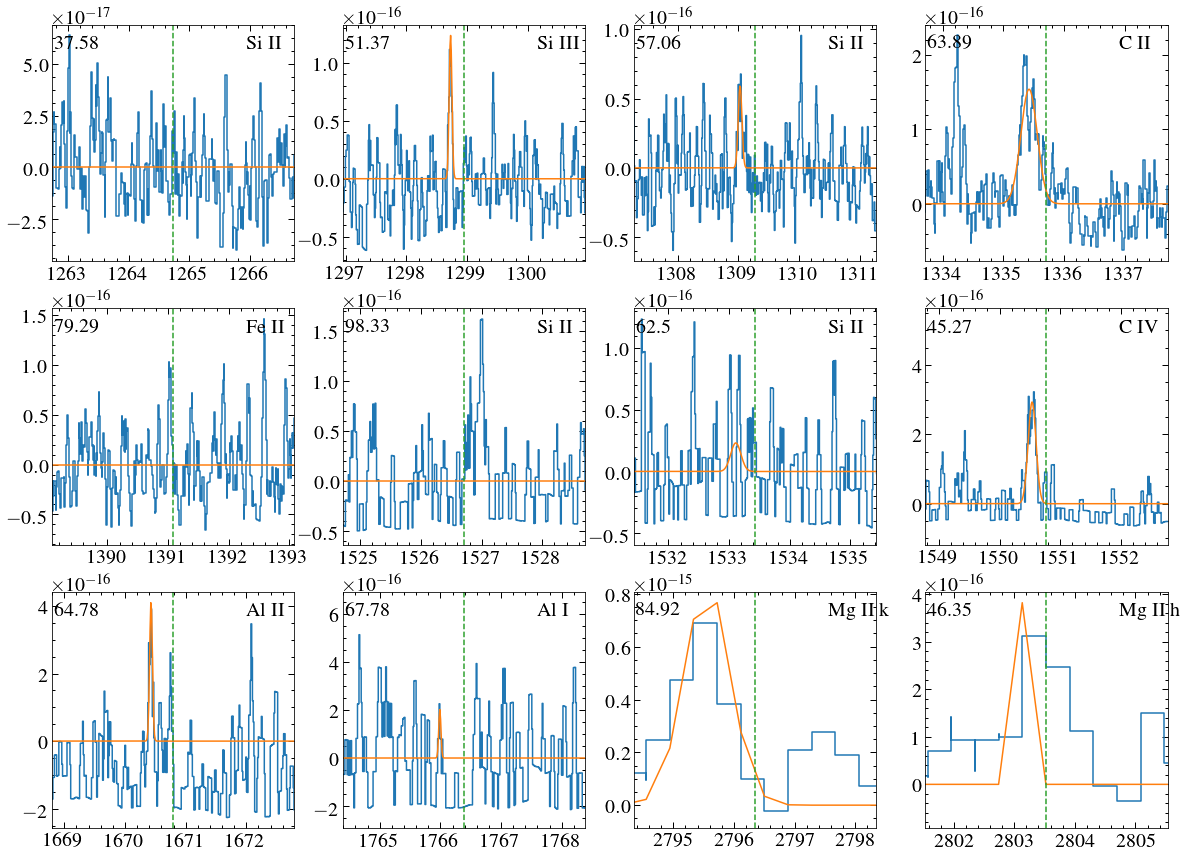

In [128]:
lines = dlines['lambda_angst']
delv=60000.
fluxes=[]
plt.figure(figsize=(20, 20))
for i in range(len(lines)):
    line = lines[i]
    plt.subplot(4,4,i+1)
    mask = (data['WAVELENGTH'] > line-5) & (data['WAVELENGTH'] < line+5)
    w = data['WAVELENGTH'][mask]
    f = data['FLUX'][mask]
    gg_init = models.Gaussian1D(4e-16, line*(1.0-(delv/c)), 0.1) #set up an intial gaussian absorption line
    gg_fit = fitter(gg_init, w, f)
    dv=c*(1-(gg_fit.mean/line))
    #print(dv/1000)
    flux = convolve(f,Box1DKernel(5))
    plt.step(w, flux)
    plt.plot(w, gg_fit(w))
    plt.axvline(line, ls='--', c='C2')
    #plt.axvline(line*(1.0-(50000/c)), ls='--', c='C3')
    plt.annotate(dlines['Species'][i], (0.8, 0.9), xycoords='axes fraction')
    plt.annotate(round(dv/1000,2), (0.01, 0.9), xycoords='axes fraction')
    plt.xlim(line-2, line+2)
    fluxes.append(np.trapz(gg_fit(w), w))

    

That worked ... way better than I expected it to... Looks like 60 was a reasonable guess for the dv?

Let's smooth them out a bit more, see if I get a better line detection.

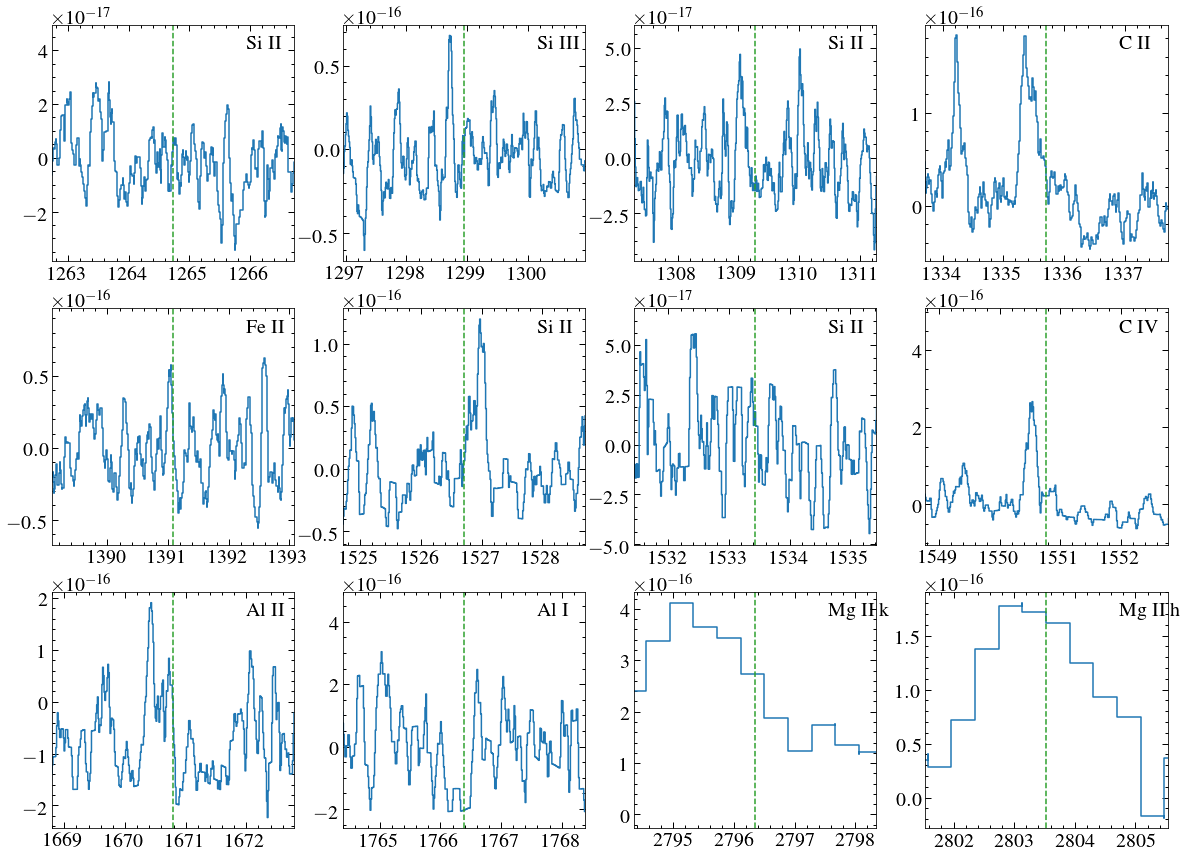

In [126]:
lines = dlines['lambda_angst']
delv=60000.
plt.figure(figsize=(20, 20))
for i in range(len(lines)):
    line = lines[i]
    plt.subplot(4,4,i+1)
    mask = (data['WAVELENGTH'] > line-5) & (data['WAVELENGTH'] < line+5)
    w = data['WAVELENGTH'][mask]
    f = data['FLUX'][mask]
    #gg_init = models.Gaussian1D(4e-16, line*(1.0-(delv/c)), 0.1) #set up an intial gaussian absorption line
    #gg_fit = fitter(gg_init, w, f)
    #dv=c*(1-(gg_fit.mean/line))
    #print(dv/1000)
    flux = convolve(f,Box1DKernel(10))
    plt.step(w, flux)
    #plt.plot(w, gg_fit(w))
    plt.axvline(line, ls='--', c='C2')
    #plt.axvline(line*(1.0-(50000/c)), ls='--', c='C3')
    plt.annotate(dlines['Species'][i], (0.8, 0.9), xycoords='axes fraction')
    #plt.annotate(round(dv/1000,2), (0.01, 0.9), xycoords='axes fraction')
    plt.xlim(line-2, line+2)
    
    

So Fe ii 1391 ish is there, don't know why it isn't fitting it? Maybe try other rvs? Or maybe it's just noise.

In [133]:
for i in range(len(lines)):
    print(dlines['Species'][i], lines[i], round(fluxes[i]/1e-18,2))

Si II 1264.73 0.0
Si III 1298.95 7.19
Si II 1309.28 4.56
C II 1335.71 52.29
Fe II 1391.08 0.0
Si II 1526.71 0.0
Si II 1533.43 4.91
C IV 1550.77 48.1
Al II 1670.79 24.04
Al I 1766.39 9.28
Mg II k 2796.35 788.64
Mg II h 2803.53 149.17


In [142]:
# temperatures of maximum ionisation from chinati feii 1391 missing, 4.6 as placeholder
temperatures = [4.5, 4.7, 4.5, 4.5, 4.6, 4.5, 4.5, 5.0,4.5,4.5,4.5, 4.5]
#temperatures = 10**np.array(temperatures)

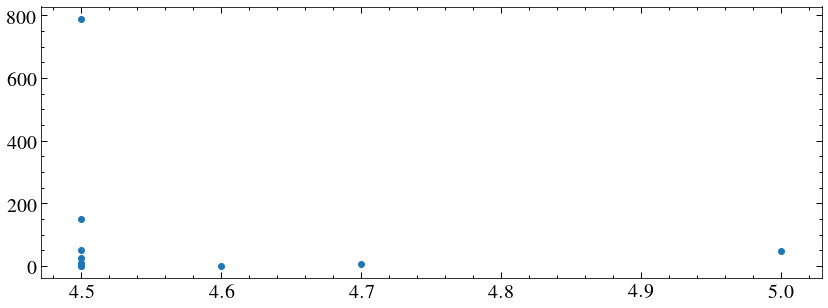

In [143]:
plt.scatter(temperatures, np.array(fluxes)/1e-18)

In [149]:
# [dlines['Model_1A'], dlines['Model_2A'], dlines['Model_2B']]
sv1a = np.array([f/mf for f, mf in zip(fluxes,dlines['Model_1A'])])
sv2a = np.array([f/mf for f, mf in zip(fluxes,dlines['Model_2A'])])
sv2b = np.array([f/mf for f, mf in zip(fluxes,dlines['Model_2B'])])
print(sv1a)

[0.00000000e+00 2.47916780e+01 4.42573747e-02 1.42859601e+00
 0.00000000e+00 0.00000000e+00 1.02968377e-01 2.80954569e+00
 7.75100740e-02 1.97014922e-02 1.13974620e-01 1.32038181e-02]


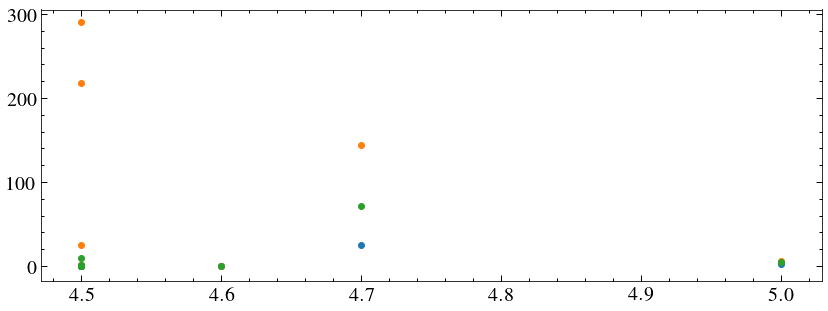

In [147]:
plt.scatter(temperatures, sv1a)
plt.scatter(temperatures, sv2a)
plt.scatter(temperatures, sv2b)
#plt.yscale('log')

So to first approximation,they're good to within 2 oom. Formation temp prehaps not the best plot, although it does show that it's better at high t - could just be upper limits, need to improve the fit. Think plotting against wavelength will look better. Also should check if the P+19 scalings are good, i.e. lyalpha / galex.

Text(0, 0.5, '$F_{\\mathrm{obs}}/F_{\\mathrm{mod}}$')

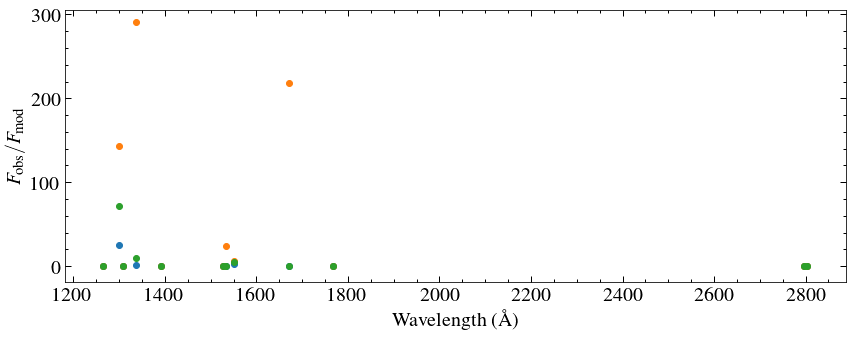

In [153]:
plt.scatter(lines, sv1a, label = ['Model 1A'])
plt.scatter(lines, sv2a, label = ['Model 2A'])
plt.scatter(lines, sv2b, label = ['Model 2B'])
plt.xlabel('Wavelength (\AA)')
plt.ylabel('$F_{\mathrm{obs}}/F_{\mathrm{mod}}$')